In [2]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split, LearningCurveDisplay, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import RocCurveDisplay, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.base import clone
#import seaborn as sns

%load_ext autoreload
%autoreload 2
    
pd.options.mode.copy_on_write = True

# Load data and model

In [159]:
df = pd.read_csv('data/augmented_dataset.csv', index_col='id')

features = [i for i in df.columns if i != 'class']
target = 'class'

X, y = df.loc[:, features], df.loc[:, target]

In [160]:
# Use the random state as in ``training.ipynb``.
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, train_size=0.9, random_state=1)

### Build a dummy classifier

In [4]:
# Dummy classifier that predics the most frequent class.
dummy = DummyClassifier(strategy='most_frequent')

In [5]:
dummy.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

### Load the model

In [6]:
model = joblib.load('saved_models/best_model.joblib')
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('reducer', PCA(n_components=50, random_state=1)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=2000, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

# Visualize the results

Text(0.5, 1.0, 'ROC curve of the best pipeline')

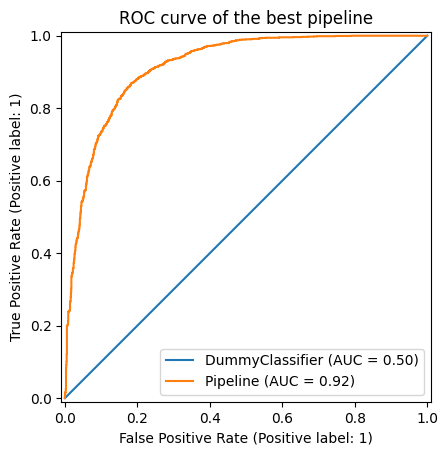

In [11]:
fig, ax = plt.subplots()

for clf in [dummy, model]:
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)
ax.set_title('ROC curve of the best pipeline')

#plt.savefig('figures/roc.pdf')

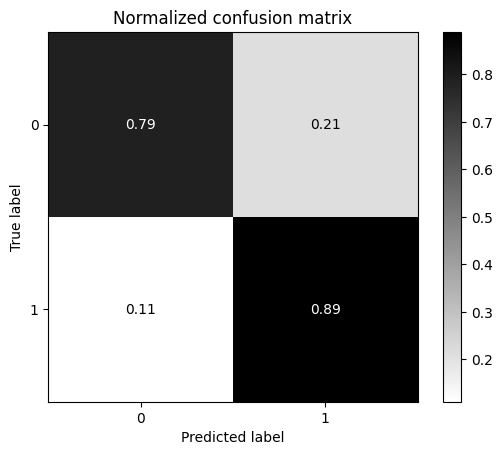

In [8]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true', cmap='binary', ax=ax)
ax.set_title('Normalized confusion matrix')

plt.savefig('figures/confusion_matrix.pdf')

In [9]:
print('Model accuracy:', model.score(X_test, y_test))

Model accuracy: 0.8380043116723129


In [10]:
scores_test = model.predict_proba(X_test)[:, 1]

In [11]:
scores_test_neg = scores_test[y_test == 0]
scores_test_pos = scores_test[y_test == 1]

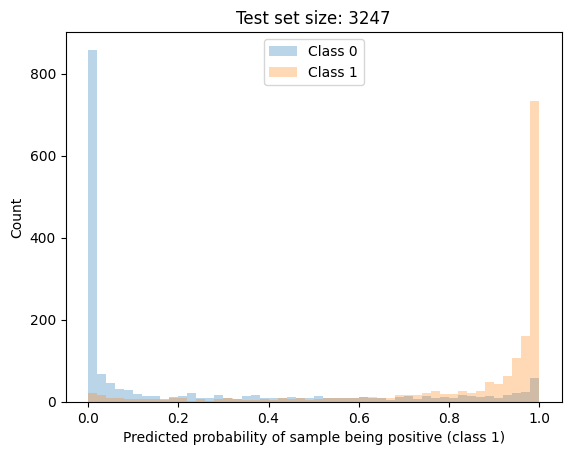

In [12]:
fig, ax = plt.subplots()

ax.hist(scores_test_neg, bins=50, label='Class 0', alpha=0.3);
ax.hist(scores_test_pos, bins=50, label='Class 1', alpha=0.3);
ax.set_ylabel('Count')
ax.set_xlabel('Predicted probability of sample being positive (class 1)')
ax.set_title(f'Test set size: {len(y_test)}')
ax.legend(loc='upper center')

plt.savefig('figures/class_scores.pdf')

# Compare with experimental data

In [14]:
df_receptor = pd.read_csv('data/Final_Receptor_dataset.csv', index_col='id')

df_ligand = pd.read_csv('data/Final_Ligand_dataset.csv', index_col='id')
df_ligand.drop('smiles', axis=1, inplace=True)

df_1lox_ligand = pd.read_csv('data/df_smiles_final.csv', index_col='Smiles 2')
df_1lox_ligand.drop('Value', axis=1, inplace=True)

In [19]:
#df_ligand = all_ligand.copy()
#df_ligand.drop(['Value', 'Smiles 2'], axis=1, inplace=True)

# Randomly sample 450 ligands.
df_ligand_random = df_ligand.sample(450, random_state=1)
print('1lox' in df_ligand_random.index)
#df_ligand_random.reset_index(inplace=True, drop=True)

# Get the values of the 50 "good" ligands.
df_1lox_ligand_selected = pd.read_csv('data/Selected 15-LOX inhibitors_NE7.csv', index_col='smiles')
df_ligand_good = df_1lox_ligand.loc[df_1lox_ligand_selected.index, :]
df_ligand_good.reset_index(inplace=True, drop=True)

False


In [21]:
df_ligand_random.to_csv('data/randomly_selected_15-lox_ligands.csv', index=True)

## Create a dataframe with receptor-ligand (using the same protein)

In [7]:
# Create dummy protein rows.
df_protein_random = pd.concat([df_receptor.loc[['1lox']]]*len(df_ligand_random), ignore_index=True)
df_protein_good = pd.concat([df_receptor.loc[['1lox']]]*len(df_ligand_good), ignore_index=True)

In [8]:
df_pairs_random = pd.concat([df_protein_random, df_ligand_random], axis=1)
df_pairs_good = pd.concat([df_protein_good, df_ligand_good], axis=1)

In [9]:
df_pairs_random.shape, df_pairs_good.shape

((450, 611), (51, 611))

In [10]:
df_pairs_good.drop_duplicates(inplace=True)

In [11]:
df_pairs_random.shape, df_pairs_good.shape

((450, 611), (50, 611))

In [12]:
preds_random = model.predict_proba(df_pairs_random)[:, 1]
preds_good = model.predict_proba(df_pairs_good)[:, 1]

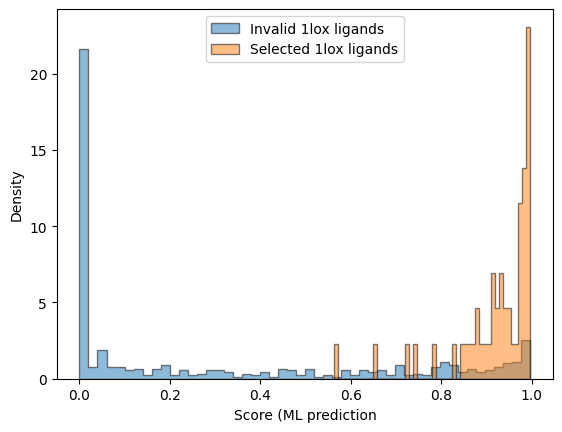

In [13]:
fig, ax = plt.subplots()

ax.hist(
    preds_random, label='Invalid 1lox ligands', density=True, bins=50,
    histtype='stepfilled', edgecolor='k', alpha=0.5
)
ax.hist(
    preds_good, label='Selected 1lox ligands', density=True, bins=50,
    histtype='stepfilled', edgecolor='k', alpha=0.5
)

ax.set_xlabel('Score (ML prediction')
ax.set_ylabel('Density')
ax.legend()

#fig.savefig('figures/1lox_random_good_hist.pdf')

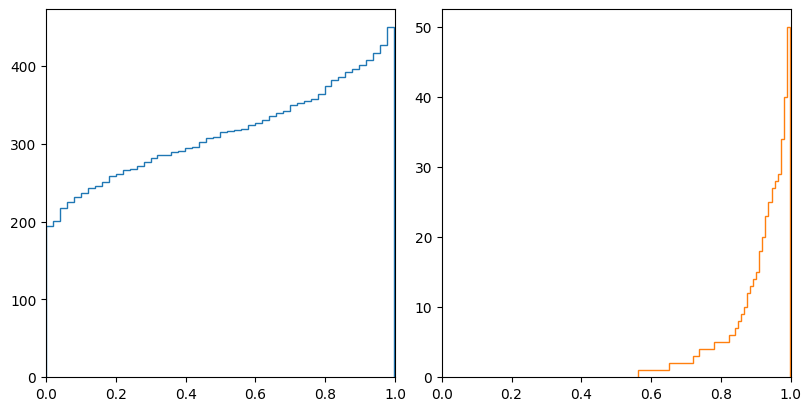

In [157]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], layout='constrained')

titles = ['random', 'good']

for i, (preds, ax, title) in enumerate(zip([preds_random, preds_good], axes.flatten(), titles)):
    ax.hist(
        preds, cumulative=True, bins=50,
        histtype='step', color=f'C{i}'
    )
    ax.set_xlim(0, 1)

In [143]:
(preds_random < 0.8).sum()

365

## Make predictions

In [18]:
preds = model.predict_proba(df_pairs)[:, 1]  # Get score for "valid".

In [19]:
df_results = all_ligand.copy()
df_results.insert(0, 'Score', preds)

In [20]:
df_results.sort_values(by='Score', ascending=False)

,Score,Value,Smiles 2,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
534,0.998637,10000.0,NC(N1c2ccccc2)=C(C(N2CCCCC2)=O)SC1=S,319.081304,319.455,4.0,2.0,2.0,1.0,5.0,...,11.618808,7.042738,3.697400,3.697400,2.600511,-1.66,14.284541,5.990545,2.731503,4.074866
228,0.997897,2511.9,CN(CN1C(CC2c(c3ccccc3cc3)c3OC)=O)CSC1=C2C#N,365.119798,365.458,5.0,0.0,2.0,0.0,5.0,...,14.729158,8.453199,4.927830,4.927830,3.732089,-2.49,16.950564,6.671788,2.643087,4.349638
233,0.997889,2511.9,COc(cc1)c(C(C2)C(C#N)=C3SCN(Cc4ccccc4)CN3C2=O)...,469.045960,470.392,5.0,0.0,4.0,0.0,5.0,...,15.968930,9.275432,5.165704,5.165704,3.792579,-2.27,20.021136,8.618312,4.061161,5.949945
290,0.997867,3162.3,CCc(cccc1)c1N(CN1C(CC2c(cccc3)c3F)=O)CSC1=C2C#N,393.131111,393.487,4.0,0.0,3.0,0.0,4.0,...,15.560681,9.283529,5.287352,5.287352,3.856852,-2.78,18.577161,7.685685,3.161323,5.099222
648,0.997694,12589.0,CCOC(c(cc1)ccc1NC(CSc1nnc(-c2ccc[s]2)[n]1C)=O)=O,402.082032,402.501,7.0,1.0,7.0,1.0,8.0,...,14.838548,8.212683,3.588619,3.588619,2.292187,-2.65,19.121039,8.827406,4.747256,6.251451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.000039,0.0,O=C(c1n[nH]nc1)Nc1ccccc1,188.069811,188.190,5.0,2.0,2.0,2.0,3.0,...,7.266777,4.082502,1.679318,1.679318,1.027628,-2.17,8.429239,3.694599,1.766430,2.224475
17,0.000037,26.0,O=C(c1n[nH]cc1)Nc(cc1)ncc1Cl,222.030839,222.635,5.0,2.0,2.0,2.0,3.0,...,7.567391,4.182168,1.702367,1.702367,1.016855,-1.88,9.666509,4.099552,2.322138,2.641891
983,0.000024,25119.0,Oc1ccc(C=CC(O2)=O)c2c1O,178.026609,178.143,4.0,2.0,0.0,2.0,4.0,...,6.520325,3.630953,1.742275,1.742275,1.107313,-1.97,7.667365,2.515851,1.120017,1.483842
523,0.000018,10000.0,Oc(c(O)c1)cc(C=C2)c1OC2=O,178.026609,178.143,4.0,2.0,0.0,2.0,4.0,...,6.520325,3.624970,1.716507,1.716507,1.092662,-1.97,7.667365,2.515851,1.219394,1.483842


In [21]:
# Write predictions to csv for later analysis.
df_results.sort_values(by='Score', ascending=False).to_csv('results/1lox_ligand_scores.csv', index=False)

In [22]:
k = 10
top_k =  (-preds).argsort()[:k]

In [23]:
top_k

array([ 534,  228,  233,  290,  648,  551, 1023,  210, 1331, 1044])

# Visualize data

In [119]:
pca_embeddings = X.copy()
pca_embeddings_pairs = df_pairs.copy()

for (name, step) in model.steps[:2]:
    pca_embeddings = step.transform(pca_embeddings)
    pca_embeddings_pairs = step.transform(pca_embeddings_pairs)

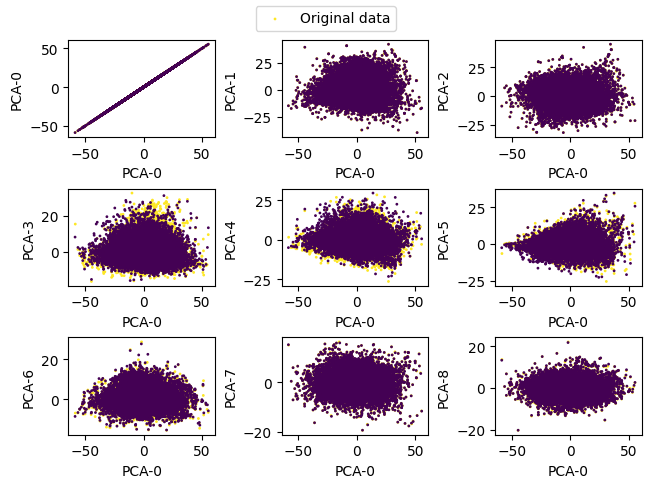

In [122]:
fig, axes = plt.subplots(3, 3, layout='constrained')

for i, ax in enumerate(axes.flatten()):
    ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, i], c='tab:green', s=1, label='Original data')
    ax.scatter(pca_embeddings_pairs[:, 0], pca_embeddings_pairs[:, i], c='tab:red', s=1, label='Data for "1lox"')
    ax.set_xlabel('PCA-0')
    ax.set_ylabel(f'PCA-{i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper center')

fig.savefig('figures/1lox_pca_scatter.png', dpi=300)

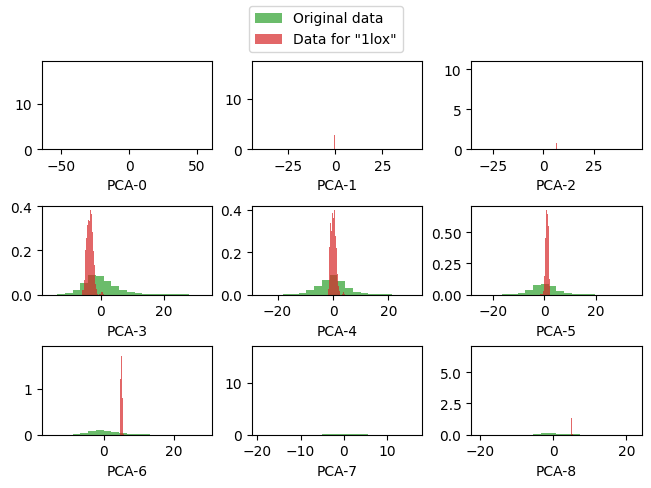

In [26]:
fig, axes = plt.subplots(3, 3, layout='constrained')

for i, ax in enumerate(axes.flatten()):
    ax.hist(pca_embeddings[:, i], color='tab:green', alpha=0.7, bins=20, density=True, label='Original data')
    ax.hist(pca_embeddings_pairs[:, i], color='tab:red', alpha=0.7, bins=20, density=True, label='Data for "1lox"')
    ax.set_xlabel(f'PCA-{i}')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper center')

fig.savefig('figures/1lox_pca_hist.pdf')

In [27]:
old_ligand = pd.read_csv('data/Final_Ligand_dataset.csv', index_col='id')

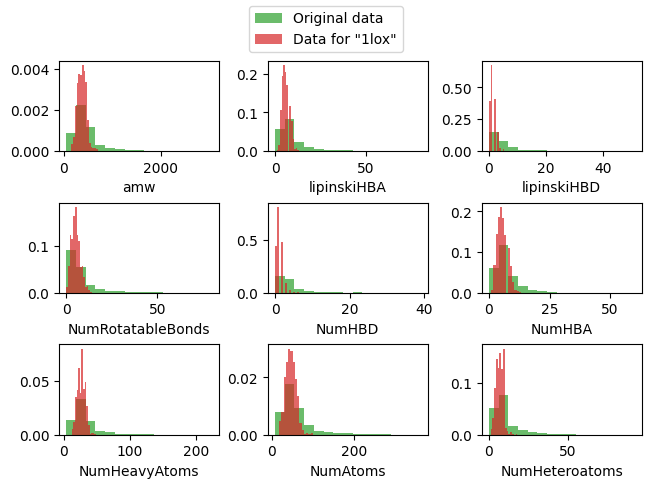

In [29]:
fig, axes = plt.subplots(3, 3, layout='constrained')

for i, ax in enumerate(axes.flatten()):
    feat = old_ligand.columns[i+2]
    ax.hist(old_ligand[feat], color='tab:green', bins=15, alpha=0.7, density=True, label='Original data')
    ax.hist(df_ligand[feat], color='tab:red', bins=15, alpha=0.7, density=True, label='Data for "1lox"')
    ax.set_xlabel(feat)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='outside upper center')

fig.savefig('figures/1lox_feats_hist.pdf')

Text(0, 0.5, 'PCA component')

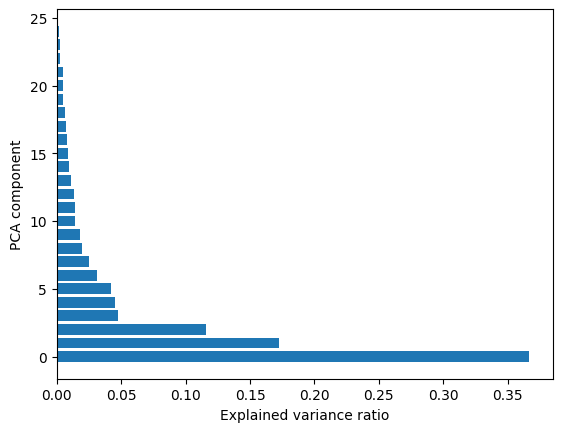

In [30]:
fig, ax = plt.subplots()

pca_ratio = model.named_steps['reducer'].explained_variance_ratio_[:25]
ax.barh(range(len(pca_ratio)), pca_ratio)
ax.set_xlabel('Explained variance ratio')
ax.set_ylabel('PCA component')

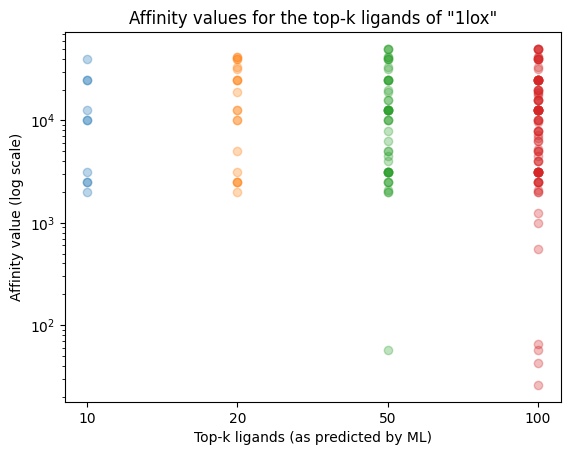

In [31]:
df_100 = df_results.sort_values(by='Score', ascending=False)[:100]

fig, ax = plt.subplots()

for i, k in enumerate(ticks := [10, 20, 50, 100]):
    ax.scatter(np.full(k, i), df_100[:k].Value, alpha=0.3)
    ax.set_yscale('log')
    ax.set_xlabel('Top-k ligands (as predicted by ML)')
    ax.set_ylabel('Affinity value (log scale)')
    ax.set_title('Affinity values for the top-k ligands of "1lox"')
ax.set_xticks(range(len(ticks)), ticks);

fig.savefig('figures/1lox_top_k.pdf')

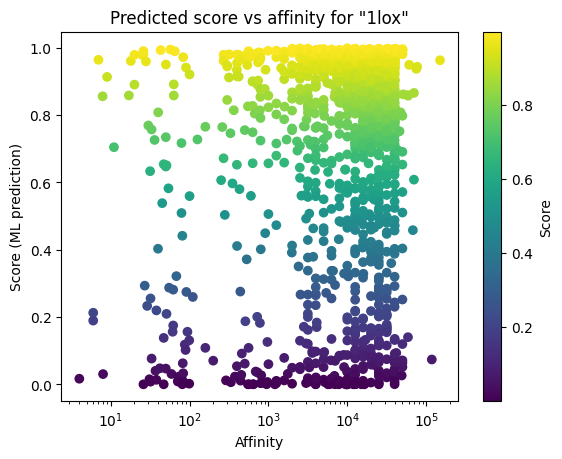

In [32]:
fig, ax = plt.subplots()

im = ax.scatter(df_results.Value, df_results.Score, c=df_results.Score)
ax.set_xscale('log')
ax.set_xlabel('Affinity')
ax.set_ylabel('Score (ML prediction)')
ax.set_title('Predicted score vs affinity for "1lox"')
fig.colorbar(im, ax=ax, label='Score')

fig.savefig('figures/1lox_score_vs_affinity.pdf')

In [50]:
print(df_results[['Score', 'Value']].sort_values(by='Score', ascending=False)[:10].to_latex(float_format='%.3f'))

\begin{tabular}{lrr}
\toprule
 & Score & Value \\
\midrule
534 & 0.999 & 10000.000 \\
228 & 0.998 & 2511.900 \\
233 & 0.998 & 2511.900 \\
290 & 0.998 & 3162.300 \\
648 & 0.998 & 12589.000 \\
551 & 0.998 & 10000.000 \\
1023 & 0.997 & 25119.000 \\
210 & 0.997 & 1995.300 \\
1331 & 0.997 & 39811.000 \\
1044 & 0.997 & 25119.000 \\
\bottomrule
\end{tabular}

